##**GPU**

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0

In [ ]:
!nvidia-smi

# **Install**

In [ ]:
!pip install torchmetrics

# **Imports 📢**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm

# **Dataset 🗂️**

## Transform

In [ ]:
transform_train = T.Compose([T.RandomCrop(32, padding=4),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                         std=(0.2023, 0.1994, 0.2010))])

transform_test = T.Compose([T.ToTensor(),
                            T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                        std=(0.2023, 0.1994, 0.2010))])

## CIFAR Dataset

In [ ]:
train_set = CIFAR10(root='./cifar10', train=True,
                    download=True,
                    transform=transform_train)

test_set = CIFAR10(root='./cifar10', train=False,
                   download=True,
                   transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_set.data.shape

(50000, 32, 32, 3)

In [ ]:
torch.FloatTensor(train_set.data/255.).mean(dim=[0, 1, 2])
torch.FloatTensor(train_set.data/255.).std(dim=[0, 1, 2])

tensor([0.2470, 0.2435, 0.2616])

In [ ]:
train_set[15]

(tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -0.4906,  ..., -0.5875, -0.5875, -0.5875],
          ...,
          [-2.4291, -2.4291,  0.7307,  ..., -1.1497, -1.1497, -1.1497],
          [-2.4291, -2.4291,  0.7888,  ..., -1.0721, -1.0721, -1.0721],
          [-2.4291, -2.4291,  0.7694,  ..., -0.9946, -1.0140, -0.9752]],
 
         [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183,  0.8858,  ...,  0.8464,  0.8464,  0.8268],
          ...,
          [-2.4183, -2.4183,  0.8858,  ..., -0.2746, -0.2352, -0.2549],
          [-2.4183, -2.4183,  1.0628,  ..., -0.2156, -0.2156, -0.2156],
          [-2.4183, -2.4183,  1.0824,  ..., -0.1369, -0.1369, -0.1172]],
 
         [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214],
          [-2.2214, -2.2214,

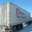

In [ ]:
train_set[15][0]

In [ ]:
train_set.classes

In [ ]:
train_set.class_to_idx

In [ ]:
len(train_set)

50000

## DataLoader

In [ ]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [ ]:
x, y = next(iter(train_loader))
print(x.shape)
print(y)

torch.Size([64, 3, 32, 32])
tensor([5, 8, 6, 0, 8, 9, 1, 4, 5, 0, 5, 2, 2, 9, 0, 4, 9, 7, 7, 1, 5, 3, 6, 2,
        2, 6, 9, 1, 1, 0, 9, 6, 6, 7, 0, 7, 6, 4, 8, 0, 9, 8, 1, 1, 5, 1, 2, 4,
        7, 8, 3, 9, 8, 7, 9, 6, 9, 2, 5, 1, 1, 3, 2, 8])


## Visualize

In [ ]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

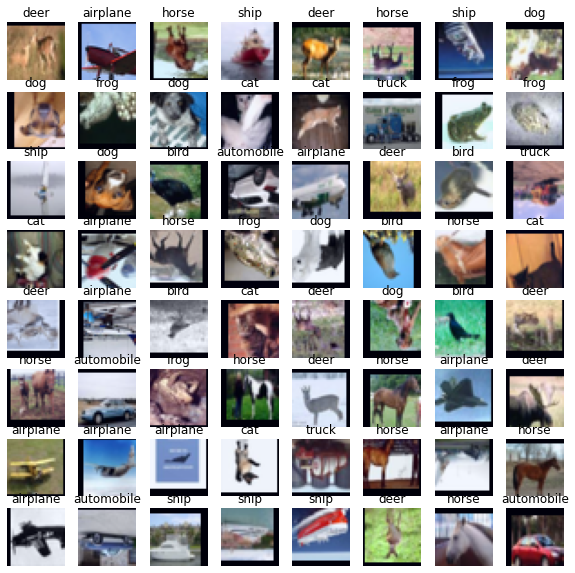

In [ ]:
batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

# **Model 🧠**

In [ ]:
def conv3x3_bn_af(in_channels, out_channels):
  module = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())
  return module

In [ ]:
def CNN():
  network = nn.Sequential(conv3x3_bn_af(3, 64),
                          conv3x3_bn_af(64, 64),
                          nn.MaxPool2d(2, 2), # 16x16

                          conv3x3_bn_af(64, 128),
                          conv3x3_bn_af(128, 128),
                          nn.MaxPool2d(2, 2), # 8x8

                          conv3x3_bn_af(128, 256),
                          conv3x3_bn_af(256, 256),
                          nn.MaxPool2d(2, 2), # 4x4

                          conv3x3_bn_af(256, 512),
                          conv3x3_bn_af(512, 512),
                          nn.AdaptiveAvgPool2d(output_size=(1, 1)), # 1x1

                          nn.Flatten(),
                          nn.Linear(512, 10) # classifier
                      )

  return network

In [ ]:
nn.AvgPool2d(4, 1)

In [ ]:
model = CNN()

In [ ]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [ ]:
num_params(model)

4.694346

# **Device ⚙️**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

In [ ]:
device

'cuda'

# **Loss & Optimizer ⚖️**

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# **Utils 🧰**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy().to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy().to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **Efficient way for set hyperparams 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [ ]:
x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(2.3413, device='cuda:0', grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [ ]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-1000, 1000))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 40.06batch/s, accuracy=99.8, loss=0.101]


## Step 3: select best lr

Train all data for one epoch

In [ ]:
num_epochs = 2
for lr in [0.1, 0.01]:
  print(f'LR={lr}')
  model = CNN().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.1


Epoch 1: 100%|█████████████████████████████████████████| 782/782 [00:38<00:00, 20.43batch/s, accuracy=77.1, loss=0.652]



LR=0.01


Epoch 1: 100%|█████████████████████████████████████████| 782/782 [00:38<00:00, 20.57batch/s, accuracy=70.6, loss=0.839]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [ ]:
num_epochs = 5

for lr in [0.08, 0.09, 0.1, 0.15, 0.2]:
  for wd in [1e-4, 1e-5, 0.]:
    model = CNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

## Step 5: train more epochs

In [ ]:
model = CNN().to(device)

In [ ]:
lr = 0.05
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|█████████████████████████████████████████| 782/782 [00:45<00:00, 17.23batch/s, accuracy=93.8, loss=0.175]


Valid: Loss = 0.6033, Acc = 0.8274



Epoch 1: 100%|███████████████████████████████████████████| 782/782 [00:44<00:00, 17.38batch/s, accuracy=94, loss=0.171]


Valid: Loss = 0.4931, Acc = 0.8487



Epoch 2: 100%|█████████████████████████████████████████| 782/782 [00:44<00:00, 17.44batch/s, accuracy=94.3, loss=0.164]


Valid: Loss = 0.556, Acc = 0.8289



Epoch 3: 100%|█████████████████████████████████████████| 782/782 [00:44<00:00, 17.44batch/s, accuracy=94.5, loss=0.155]


Valid: Loss = 0.4714, Acc = 0.8571



Epoch 4: 100%|█████████████████████████████████████████| 782/782 [00:45<00:00, 17.28batch/s, accuracy=94.8, loss=0.146]


Valid: Loss = 0.3287, Acc = 0.8964



Epoch 5: 100%|█████████████████████████████████████████| 782/782 [00:44<00:00, 17.44batch/s, accuracy=95.3, loss=0.134]


Valid: Loss = 0.5268, Acc = 0.8501



Epoch 6: 100%|██████████████████████████████████████████| 782/782 [00:44<00:00, 17.46batch/s, accuracy=95.5, loss=0.13]


Valid: Loss = 0.451, Acc = 0.8659



Epoch 7: 100%|█████████████████████████████████████████| 782/782 [00:44<00:00, 17.43batch/s, accuracy=95.6, loss=0.125]


Valid: Loss = 0.4643, Acc = 0.868



Epoch 8: 100%|█████████████████████████████████████████| 782/782 [00:44<00:00, 17.59batch/s, accuracy=95.7, loss=0.122]


Valid: Loss = 0.4802, Acc = 0.8662



Epoch 9: 100%|█████████████████████████████████████████| 782/782 [00:43<00:00, 17.89batch/s, accuracy=95.9, loss=0.116]


Valid: Loss = 0.4763, Acc = 0.8711



# **Plot**

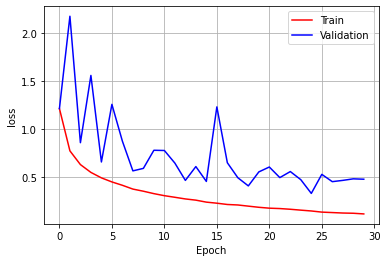

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

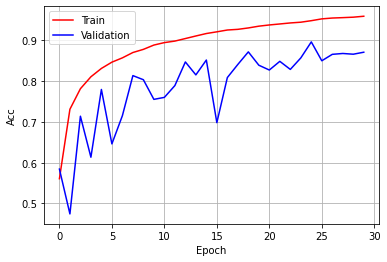

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()